## Introduction: 

The notebook attempts to cluster the trajectories of different taxi's in Beijing.

The notebook is divided into three section:

1. Data Preprocessing
2. Data Extrapolation
3. Clustering

As many steps in the notebook are time consuming, it is not required to run the whole notebook.
Please select the section of your interest and start working from there.
All the processed csv files required to run this notebook are present with the repository.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point, LineString
from sklearn.preprocessing import StandardScaler
from dateutil import rrule
import datetime
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

%matplotlib inline

# 1. Data Preprocessing

In [57]:
# import data
df_main = pd.read_csv('20190425_trajectories.csv')

# view the data
print(df_main.shape)
print('Unique Trips:', len(df_main['trip_id'].unique()))
df_main.head()

(258273, 6)
Unique Trips: 7079


,trip_id,timestamp,long,lat,time,count
0,2396,2008-02-06 20:00:21,116.31790,39.88848,620,1
1,2396,2008-02-06 20:05:22,116.34790,39.88807,620,1
2,2396,2008-02-06 20:10:24,116.35255,39.88706,620,1
3,2396,2008-02-06 20:15:26,116.35076,39.90324,620,1
4,2396,2008-02-06 20:20:28,116.35767,39.94459,620,1


In [59]:
# Apply Filter to remove noisy trajectories
df_main = df_main[~df_main['trip_id'].isin(df_main[(df_main['long'] > 116.6) + (df_main['long'] < 115.8)\
+ (df_main['lat'] > 40.0) + (df_main['lat'] < 39.4)]['trip_id'].unique())]

# view the data
print(df_main.shape)
print('Unique Trips:', len(df_main['trip_id'].unique()))
df_main.head()

(152010, 6)
Unique Trips: 4234


,trip_id,timestamp,long,lat,time,count
43,8793,2008-02-07 20:03:01,116.34055,39.88395,720,1
44,8793,2008-02-07 20:03:33,116.34052,39.88393,720,1
45,8793,2008-02-07 20:08:01,116.34410,39.87645,720,1
46,8793,2008-02-07 20:09:12,116.34523,39.87924,720,1
47,8793,2008-02-07 20:14:12,116.34848,39.88201,720,1


In [15]:
print('No.of unique trips:', len(df_main['trip_id'].unique()))
print('No.of positional records:', len(df_main))

No.of unique trips: 4234
No.of positional records: 152010


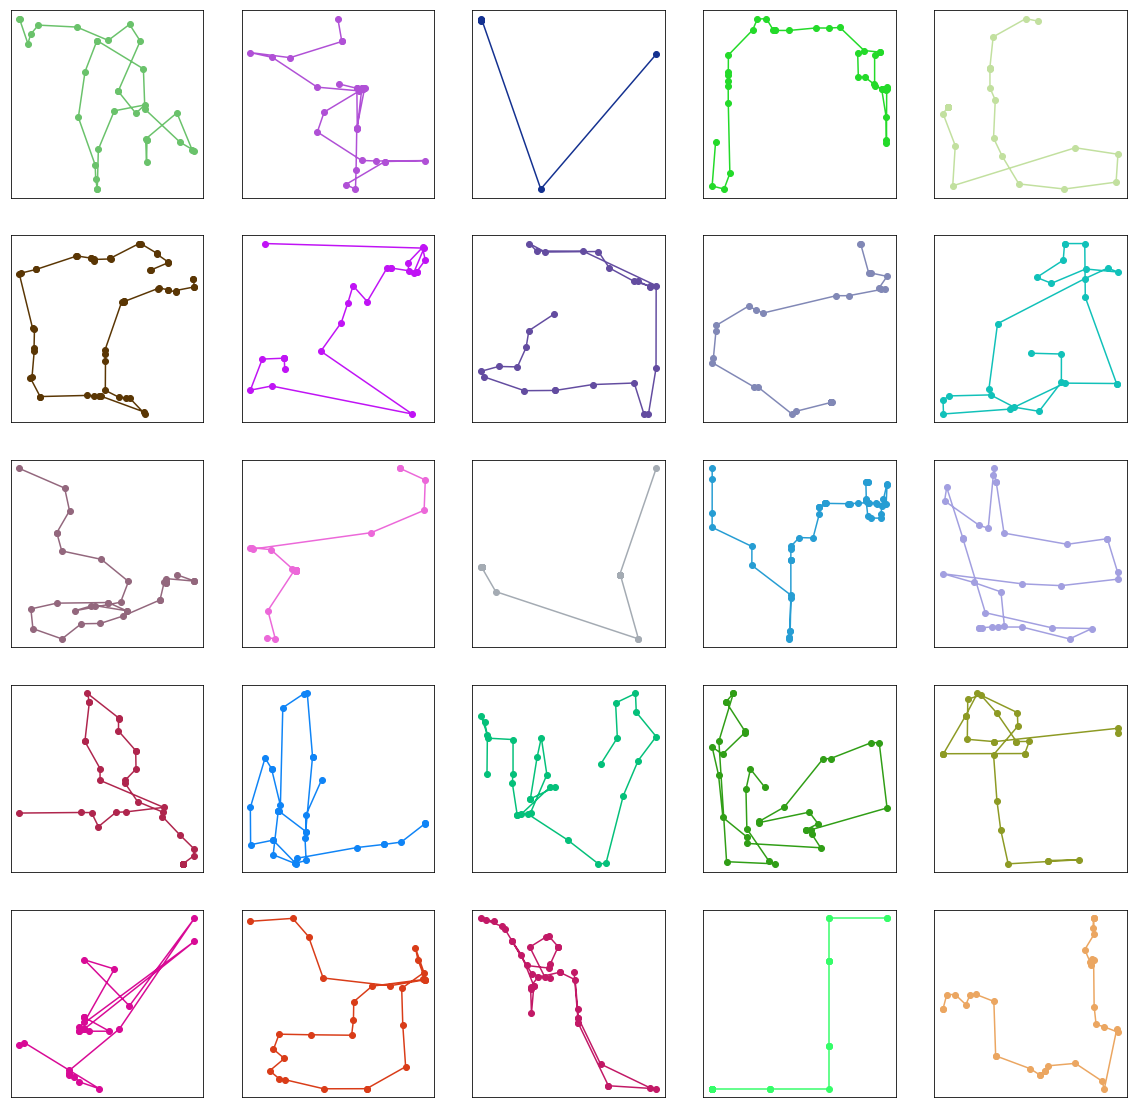

In [12]:
# plot some sample trajectories
plt.subplots(figsize= (20, 20))
a = 1
for i in df_main['trip_id'].unique()[0:25]:
    plt.subplot(5,5,a)
    plt.plot(df_main.loc[df_main['trip_id']==i, 'long'], df_main.loc[df_main['trip_id']==i,'lat'], marker = 'o', c= np.random.rand(3,))
    a = a + 1
    plt.xticks([])
    plt.yticks([])
plt.savefig('IndiviDualTrajectories.png')

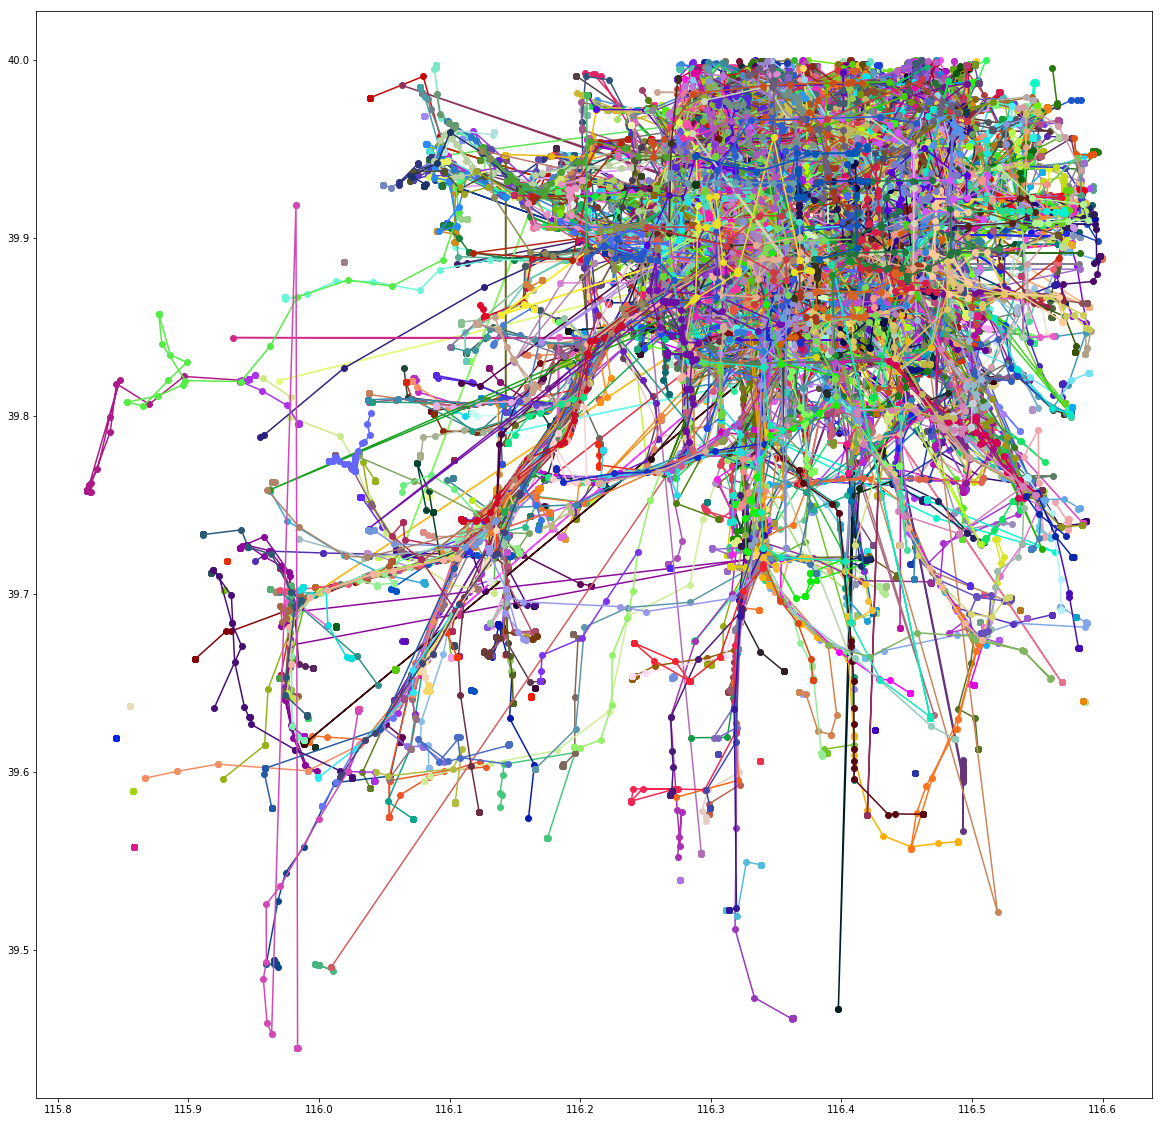

In [16]:
# plot all the trajectories
plt.subplots(figsize= (20, 20))
a = 1
for i in df_main['trip_id'].unique():
    plt.plot(df_main.loc[df_main['trip_id']==i, 'long'], df_main.loc[df_main['trip_id']==i,'lat'],\
             marker = 'o',  c= np.random.rand(3,))
plt.savefig('AllTrajectories.png')

In [24]:
# drop unneccesary columns
df_main.drop(['time','count'], axis=1, inplace= True)

# rename columns
df_main.columns = ['trip_id', 'time', 'x', 'y']

# view the data
print(df_main.shape)
df_main.head()

(152010, 4)


,trip_id,time,x,y
43,8793,2008-02-07 20:03:01,116.34055,39.88395
44,8793,2008-02-07 20:03:33,116.34052,39.88393
45,8793,2008-02-07 20:08:01,116.34410,39.87645
46,8793,2008-02-07 20:09:12,116.34523,39.87924
47,8793,2008-02-07 20:14:12,116.34848,39.88201


In [25]:
# save processed data
df_main.to_csv('20190425_ProcessedTaxiTrajectories.csv', index = False)

# 2. Data Extrapolation

In [62]:
# import data
df_main = pd.read_csv('20190425_ProcessedTaxiTrajectories.csv')

# view the data
print(df_main.shape)
df_main.head()

(152010, 4)


,trip_id,time,x,y
0,8793,2008-02-07 20:03:01,116.34055,39.88395
1,8793,2008-02-07 20:03:33,116.34052,39.88393
2,8793,2008-02-07 20:08:01,116.34410,39.87645
3,8793,2008-02-07 20:09:12,116.34523,39.87924
4,8793,2008-02-07 20:14:12,116.34848,39.88201


In [63]:
# change time to pd.datetime
df_main['time'] = pd.to_datetime(df_main['time'])
print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152010 entries, 0 to 152009
Data columns (total 4 columns):
trip_id    152010 non-null int64
time       152010 non-null datetime64[ns]
x          152010 non-null float64
y          152010 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.6 MB
None


,trip_id,time,x,y
0,8793,2008-02-07 20:03:01,116.34055,39.88395
1,8793,2008-02-07 20:03:33,116.34052,39.88393
2,8793,2008-02-07 20:08:01,116.34410,39.87645
3,8793,2008-02-07 20:09:12,116.34523,39.87924
4,8793,2008-02-07 20:14:12,116.34848,39.88201


### Function for Extrapolation

1. First, for each trip extract the earliest record present in the main data.
2. Make 24 timesteps with 5 minutes interval from the time of this earliest record.
3. For each of these timesteps apply the function 'findxy' to get extrapolated position.

**Function findxy:**
1. If the timestep is equal to time of any original record, return the x and y from the original record.
2. Else, find the latest original record before(min) and the earliest original record after(max) the given timestep.
3. Extrapolate the position using formula:
(Pmax - Pmin) * ((Ttimestep - Tmin)/(Tmax -Tmin))

In [64]:
def findxy(row):
    
    if len(df_temp[df_temp['time']==row['Timestep']]) > 0:
        temp_x = np.array(df_temp[df_temp['time']==row['Timestep']]['x'])[0]
        temp_y = np.array(df_temp[df_temp['time']==row['Timestep']]['y'])[0]

    else:
        try:
            arg_min = np.argmax(df_temp[df_temp['time']<row['Timestep']]['time'])
        except:
            arg_min = -1
        try:
            arg_max = np.argmin(df_temp[df_temp['time']>row['Timestep']]['time'])
        except:
            arg_max = -1

        if arg_min == -1:
            arg_min = arg_max
            arg_max = np.argmin(df_temp[df_temp['time']>df_temp.loc[arg_max, 'time']]['time'])
        if arg_max == -1:
            arg_max = arg_min
            arg_min = np.argmax(df_temp[df_temp['time']<df_temp.loc[arg_min, 'time']]['time'])
        
        temp_x = df_temp.loc[arg_min, 'x'] + (((row['Timestep'] - df_temp.loc[arg_min, 'time'])\
                                               /(df_temp.loc[arg_max, 'time'] - df_temp.loc[arg_min, 'time']))*\
                                              (df_temp.loc[arg_max, 'x'] - df_temp.loc[arg_min, 'x']))
        
        temp_y = df_temp.loc[arg_min, 'y'] + (((row['Timestep'] - df_temp.loc[arg_min, 'time'])\
                                               /(df_temp.loc[arg_max, 'time'] - df_temp.loc[arg_min, 'time']))*\
                                              (df_temp.loc[arg_max, 'y'] - df_temp.loc[arg_min, 'y']))
    
    return temp_x, temp_y


In [100]:
# initiate a empty df for storing extrapolated data
df_extrapolate = pd.DataFrame()

# for each unique trip in the data
for trip in df_main['trip_id'].unique():
    
    # subset data for the given trip
    df_temp = df_main[df_main['trip_id']==trip]
    
    # find the first record of the trip and save its time
    min_time = df_temp['time'].min()
    
    # find the first record of the trip and save its time
    max_time = df_temp['time'].max()
    
    # The time difference between the first and last record we want i.e: 2hrs
    diff = np.timedelta64(7200,'s')
    
    if max_time - min_time > np.timedelta64(6000,'s'):
        try:
            # Make a dataframe having 24 timesteps with fixed time interval of 5minutes
            # between the time of first record of trip and 2 hrs after that.
            df_output = pd.DataFrame(list(rrule.rrule(rrule.MINUTELY, interval=5, dtstart= min_time + datetime.timedelta(minutes=1)\
                                                      , until= min_time+ diff)), columns = ['Timestep'])
            # store the trip id
            df_output['trip_id'] = trip

            # define the step feature: To be used later during clustering
            df_output['step'] = np.arange(0,24,1)

            # Obtain the extrapolated x & y coordinates for the defined timesteps
            df_output['x'], df_output['y'] = zip(*df_output.apply(lambda x: findxy(x), axis= 1))

            # append the extrapolated records for the trip
            # to the df_extrapolate data frame defined before
            df_extrapolate = df_extrapolate.append(df_output)

            # delete all the temporary variables created
            del df_temp, min_time, diff, df_output

        except:
            # delete all the temporary variables created
            del df_temp, min_time, diff


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [118]:
# Remove noise
df_extrapolate = df_extrapolate[~df_extrapolate['trip_id'].isin\
                                (df_extrapolate[(df_extrapolate['x'] > 117) + (df_extrapolate['x'] < 114) + \
                                                (df_extrapolate['y'] > 41.0) + (df_extrapolate['y'] < 35.0)]['trip_id'].unique())]

In [120]:
# view the data
print(df_extrapolate.shape)
df_extrapolate.head()

(86688, 5)


,Timestep,trip_id,step,x,y
0,2008-02-07 20:04:01,8793,0,116.340894,39.883149
1,2008-02-07 20:09:01,8793,1,116.345055,39.878808
2,2008-02-07 20:14:01,8793,2,116.348361,39.881908
3,2008-02-07 20:19:01,8793,3,116.364163,39.881451
4,2008-02-07 20:24:01,8793,4,116.377543,39.877596


In [121]:
# save the data
df_extrapolate.to_csv('20190425_Extrapolate.csv', index = False)

# 3.  Clustering

In [122]:
# import data
df_extrapolate = pd.read_csv('20190425_Extrapolate.csv')

# view the data
print(df_extrapolate.shape)
print(len(df_extrapolate['trip_id'].unique()))
df_extrapolate.head()

(86688, 5)
3612


,Timestep,trip_id,step,x,y
0,2008-02-07 20:04:01,8793,0,116.340894,39.883149
1,2008-02-07 20:09:01,8793,1,116.345055,39.878808
2,2008-02-07 20:14:01,8793,2,116.348361,39.881908
3,2008-02-07 20:19:01,8793,3,116.364163,39.881451
4,2008-02-07 20:24:01,8793,4,116.377543,39.877596


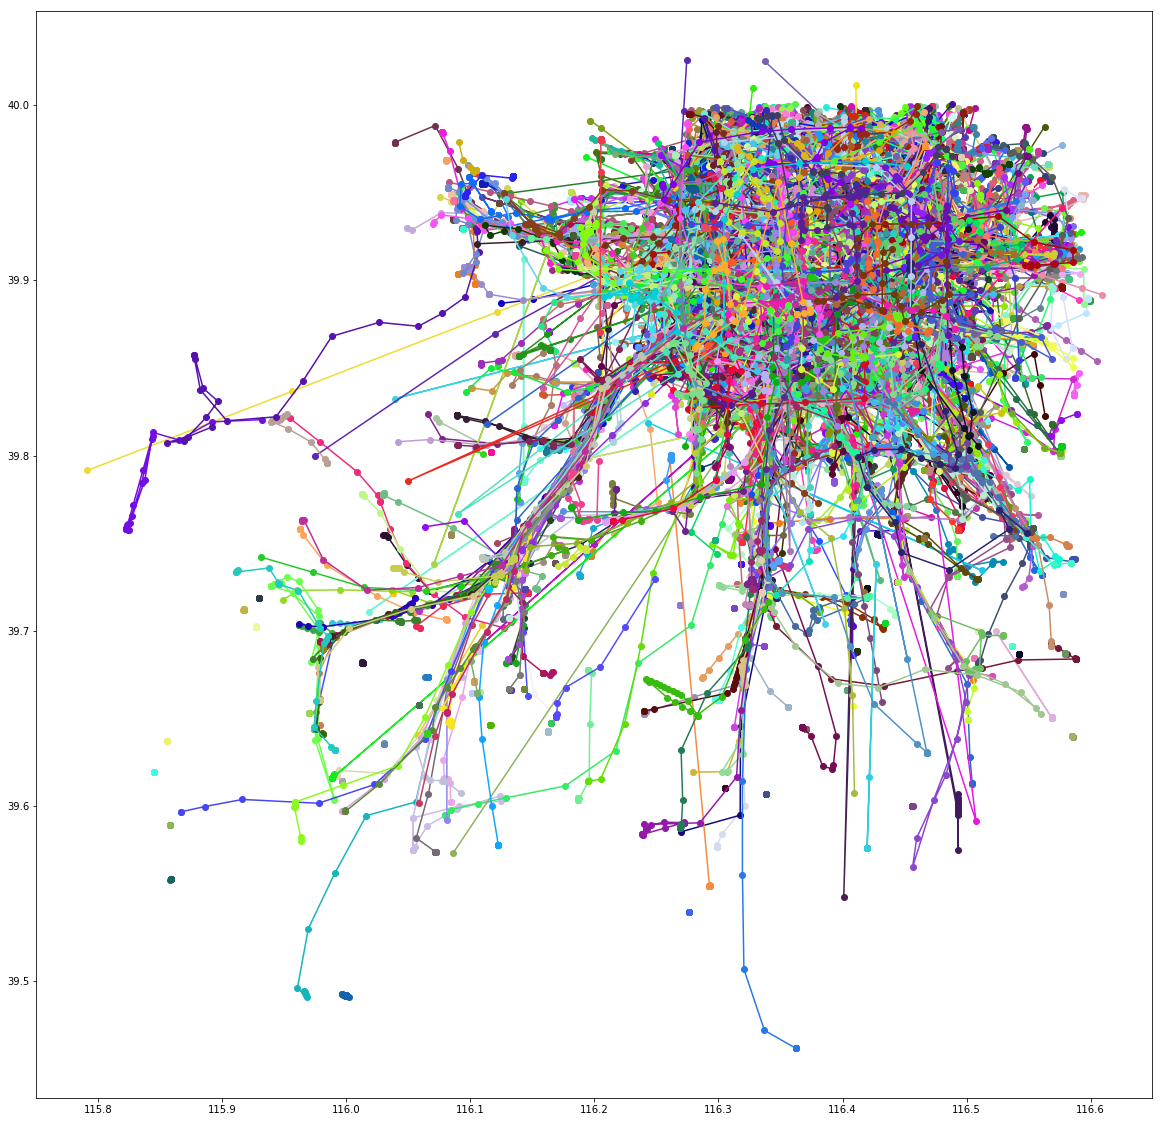

In [119]:
# plot data
plt.subplots(figsize= (20, 20))
for i in df_extrapolate['trip_id'].unique():
    plt.plot(df_extrapolate.loc[df_extrapolate['trip_id']==i, 'x'], df_extrapolate.loc[df_extrapolate['trip_id']==i,'y'],\
             marker = 'o',  c= np.random.rand(3,))
plt.savefig('ExtrapolatedTrajectories.png')

In [123]:
# reshape the data for clustering
df_cluster = pd.pivot(df_extrapolate, index = 'trip_id', columns = 'step', values = ['x','y'])

In [124]:
# standardize data with zero mean and unit variance
scaler = StandardScaler()
X= scaler.fit_transform(df_cluster)

In [125]:
# get silhoutte curve
silhouette=[]
range_n_clusters = range(2,100)
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    #report average Silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.593637606697708
For n_clusters =3, the average silhouette_score is :0.24226751065575625
For n_clusters =4, the average silhouette_score is :0.24494987946992652
For n_clusters =5, the average silhouette_score is :0.22526010578649797
For n_clusters =6, the average silhouette_score is :0.2218603880248549
For n_clusters =7, the average silhouette_score is :0.19550470255978833
For n_clusters =8, the average silhouette_score is :0.1966935408473829
For n_clusters =9, the average silhouette_score is :0.18326759354587435
For n_clusters =10, the average silhouette_score is :0.16900997606316678
For n_clusters =11, the average silhouette_score is :0.15830043683387127
For n_clusters =12, the average silhouette_score is :0.16204086707787507
For n_clusters =13, the average silhouette_score is :0.15948574858098338
For n_clusters =14, the average silhouette_score is :0.1510201667101113
For n_clusters =15, the average silhouette_score is :0.151791529

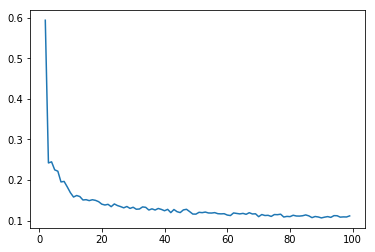

In [126]:
# plot silhouette curve
plt.plot(range(2,100), silhouette,'-')
plt.savefig('silhoutte.png')

In [127]:
# K-Mean Clustering
km = KMeans(n_clusters=2, random_state=324)

# Get cluster labels
df_labels = pd.DataFrame(km.fit_predict(X), index = df_cluster.index, columns = ['Label'])

In [128]:
# merge cluster labels with extrapolated data
df_extrapolate = df_extrapolate.merge(df_labels, left_on = 'trip_id', right_on = df_labels.index, how ='left' )

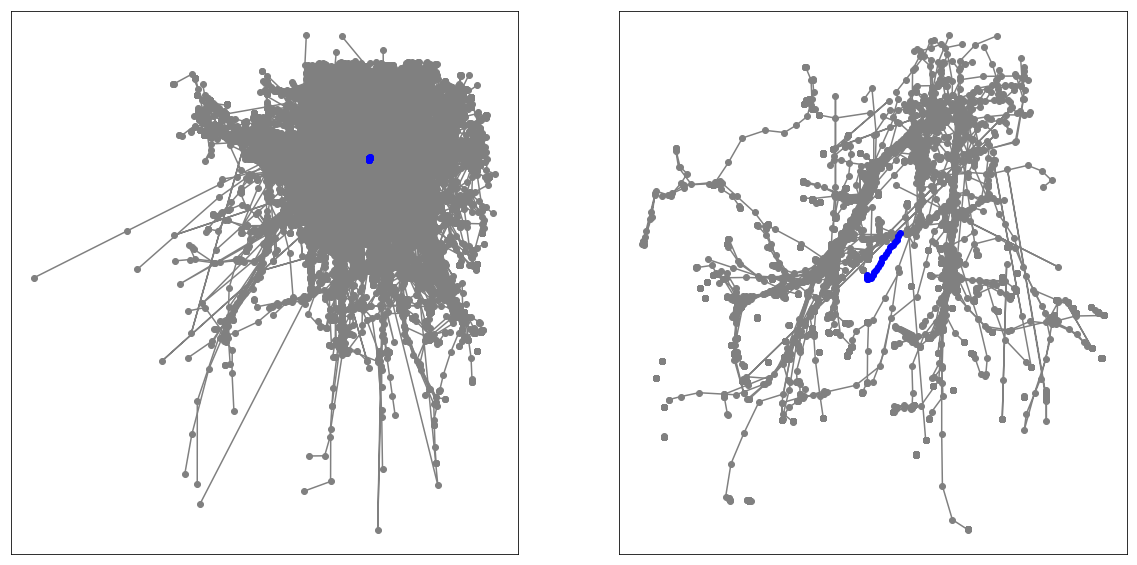

In [133]:
# Plot final clusters
plt.subplots(figsize= (20, 10))

for i in df_extrapolate['Label'].unique():
    
    plt.subplot(1,2,i+1)
    df_temp = df_extrapolate[df_extrapolate['Label']==i]
    
    # Plot all the trajectory in the cluster
    for j in df_temp['trip_id'].unique():
        plt.plot(df_temp.loc[df_temp['trip_id']==j, 'x'], df_temp.loc[df_temp['trip_id']==j, 'y'], marker = 'o', color = 'grey')
    
    # plot centroids of the cluster
    plt.plot(df_temp.groupby(['step'])['x','y'].mean()['x'], df_temp.groupby(['step'])['x','y'].mean()['y'], marker = 'o', color = 'blue')
    
    plt.xticks([])
    plt.yticks([])
plt.savefig('FinalClusterCentroids.png')